In [1]:
import os
import glob
import numpy as np
# import librosa
from pathlib import Path

# import soundfile as sf
import pandas as pd
import tqdm

import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
import librosa

Beat_FPS = 100

def bool_sec2frames(beat_ann, bool_secarray, FPS=Beat_FPS):
    bool_farray = np.zeros((1, int(beat_ann[-1]*FPS)+1))
    start_frames = [int(i*FPS) for i in beat_ann[:-1][bool_secarray]]
    end_frames = [int(i*FPS) for i in beat_ann[1:][bool_secarray]]
    
    for ind, start_frame in enumerate(start_frames):
        bool_farray[0, start_frame:end_frames[ind]]=True
    
    return bool_farray

def normalIBIboolarray(beat_ann, t_range = (10, 301), FPS = 100):
    """
    convert beat annotations into frame-based representation, 
    extract extreme-tempo cases as boolean values, represent as array (frame base) 

    Parameters
    ----------
    beat_ann : TYPE
        DESCRIPTION.
    t_range : TYPE, optional
        DESCRIPTION. The default is (10, 300).
    FPS : TYPE, optional
        DESCRIPTION. The default is 100.

    Returns
    -------
    None.

    """
    
    lowlimit, uplimit = t_range
    ibis = beat_ann[1:] -beat_ann[:-1]
    tempi = 60/ibis
    
    fast_bool = tempi>=uplimit
    slow_bool = tempi<lowlimit
    
    fast_barray = bool_sec2frames(beat_ann, fast_bool)
    slow_barray = bool_sec2frames(beat_ann, slow_bool)    

    cat_array = np.vstack([fast_barray, slow_barray])
    return cat_array

def abnmIBIvis( bool_array, fontsize = 10, xinterval = 50, figsize = (7, 2)):
    ### xinterval: interval for xtick in seconds
    y_tick_dict ={
        'faster':'Faster', 
        'slower':'Slower', 
        } 

    c_types=['faster', 'slower'] # criteria types
    c_ticks = {y_tick_dict[y]:ind for ind, y in enumerate(c_types)}

    fig, ax = plt.subplots(1, 1, figsize = figsize)
    ax.imshow(bool_array, aspect = 'auto', cmap = 'Oranges', interpolation='none')
    ax.set_yticks(range(len(c_ticks)) )
    ax.grid(axis='y', linewidth = 1)
    ax.set_yticklabels(c_ticks, fontsize = fontsize)
    ax.tick_params(axis = 'y', rotation = 0)
    xticks = np.arange(0, int(len(bool_array.T)), xinterval*Beat_FPS)
    ax.set_xticks(xticks)
    xlabel_values = xticks/Beat_FPS
    ax.set_xticklabels(xlabel_values.astype(int))
    ax.set_xlabel('Time (seconds)', fontsize = fontsize)
    return fig

###################################################################################################
# 1. Read the csv file for the pre-calculated statistics of the ASAP beat annotations.
# 2. Display the top 10 tracks with abnormal annotations 
#     (i.e., with IBIs fall outside the pre-defined min/max tempo range, 10-300 BPM)
###################################################################################################
target_set = 'ASAP'
count_faster_threshold = 20
display_rows = 5

csv_folder = './'
csv_rpath = os.path.join(csv_folder, 'annotation-statistics.csv')
all_df = pd.read_csv(csv_rpath)

datasets = all_df['Dataset'].unique().tolist()
display_keys = ['Dataset', 'Wavpath', 
                'min_max_temporange', 'mean_tempo', 'min_tempo',
                'max_tempo', 'count_slower', 'count_faster', 'num_ibis', 
               ]
all_df_sort = all_df.sort_values(by  =['count_faster'], ascending = False)
dfs_select = all_df_sort.loc[
 (all_df_sort['count_faster'] >= count_faster_threshold) &
 (all_df_sort['Dataset']==target_set)
]

display_df = dfs_select.loc[:, display_keys].iloc[:display_rows, :]
display(display_df)

,Dataset,Wavpath,min_max_temporange,mean_tempo,min_tempo,max_tempo,count_slower,count_faster,num_ibis
407,ASAP,Liszt_Mephisto_Waltz_Tysman07M.wav,"(10, 300)",324.72,9.75,5758.16,1,1562,2601
384,ASAP,Liszt_Mephisto_Waltz_ChenGuang24M.wav,"(10, 300)",326.67,6.88,1510.57,1,1506,2601
333,ASAP,Liszt_Mephisto_Waltz_ChernovA04M.wav,"(10, 300)",311.68,5.78,1181.57,2,1504,2601
162,ASAP,Chopin_Scherzos_31_SunD04M.wav,"(10, 300)",306.45,54.99,9600.00,0,1186,2337
253,ASAP,Chopin_Scherzos_20_Kurz04M.wav,"(10, 300)",311.84,29.62,1535.71,0,1167,1872


In [2]:
def add_click(audio, beat_time, sr, click_freq = 1000 ):
    if len(audio.shape)>1 and audio.shape[1]==2:
        audio = audio.sum(axis = 1)/2
        print("audio to mono:", audio.shape)
    click = librosa.clicks(times = beat_time, sr = sr, click_freq = click_freq, length = len(audio))
    audio_withclick = audio + 0.4*click
    return audio_withclick

def getSRCs(selected_track_wavpath, dataset = 'ASAP'):
    """
    get annpath, wav, activation, estimation of this selected track, and return in a dict

    Parameters
    ----------
    selected_track : TYPE
        DESCRIPTION.

    Returns
    -------
    src_dict : TYPE
        DESCRIPTION.

    """
    modelfolder_dict = {
         'ASAP': ('./estimations', 
                  './activations', 
                 './annotations'),
           
        }
    est_folder, acti_folder, ann_folder = modelfolder_dict[dataset]
    src_dict = {
        'annpath': os.path.join(ann_folder, os.path.basename(selected_track_wavpath).replace('.wav', '.beats')), 
        'wavpath': selected_track_wavpath, 
        'actipath': os.path.join(acti_folder, os.path.basename(selected_track_wavpath).replace('.wav', '.npy')),
        'estipath': os.path.join(est_folder, os.path.basename(selected_track_wavpath).replace('.wav', '.beats')),
        }
    
    
    return src_dict

def plotSRCs(src_dict, annshift = None, figsize = (12, 8), fontsize = 11, start_frame = 0, dur = 1000):
    #%%
    ### get audio
    wavform, rate = sf.read(src_dict['wavpath'])
    if len(wavform.shape)>=2:
        wavform = wavform.mean(axis = 1)
    ### get beat ann
    beat_ann = np.loadtxt(src_dict['annpath'])[:, 0]
    ### get beat est
    try:
        beat_est = np.loadtxt(src_dict['estipath'])
    except:
        beat_est = np.loadtxt(src_dict['estipath'].replace('.beats', '.txt'))
    ### get shifted beats
    # beat_annshift = beat_ann + annshift*0.001
    ### get activations
    mmacti = np.load(src_dict['actipath'])
    max_acti = mmacti.max(axis = 1)
    
    figheight1 = max_acti.max()+0.1
    fig, axs = plt.subplots(2, 1, figsize = figsize)

    
    ### plot activation with time stamps (beat ann, est, shifted ann)
    axs[0].plot(max_acti, label = 'max-activation', color = 'red', linewidth = 4)
    ### convert x ticks from frames to seconds
    xticks = np.arange(0, int(len(max_acti)), 100)
    axs[0].set_xticks(xticks)
    axs[0].set_xticklabels(xticks/Beat_FPS)
    
    axs[0].set_xlim([start_frame, start_frame + dur])
    axs[0].set_ylim([0, figheight1])
    axs[0].vlines(beat_ann*Beat_FPS, 0, 1, linestyle = 'solid', 
                  label = 'original annotation', color = 'black', linewidth = 2, alpha = 1)
    axs[0].vlines(beat_est*Beat_FPS, 0, 1, linestyle = 'dashed', linewidth = 3, 
                  label = 'sppk estimation', color = 'gray', alpha = 0.6)
    # annshift_label = str(annshift) + 'ms shifted annotation'
    # axs[0].vlines(beat_annshift*Beat_FPS, 0, 1, linestyle = 'solid', linewidth = 6, alpha = 0.4, 
                  # label = annshift_label, color = 'orange')
    
    # axs[0].legend(bbox_to_anchor = (1.0, 1.0))
    axs[0].legend(loc='upper center', bbox_to_anchor = (0.5, 1.4), 
                     frameon=False, fontsize = fontsize, ncol=4, 
                     handletextpad=0.3, columnspacing= 0.7)
    # axs[0].set_xlabel('Time (frame, FPS=100)', fontsize = fontsize)
    axs[0].set_xlabel('Time (second)', fontsize = fontsize)
    
    ### plot wavform with time stamps (beat ann, est, shifted ann)
    figheight2 = wavform.max()+0.1
    figlow = wavform.min()-0.1
    axs[1].plot(wavform, label = 'audio-waveform', color = 'blue', linewidth = 4, alpha = 0.7)
    ### convert x ticks from samples to seconds
    xticks = np.arange(0, int(len(wavform)), rate)
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(xticks/rate)
    
    axs[1].set_xlim([start_frame/Beat_FPS*rate, start_frame/Beat_FPS*rate + dur/Beat_FPS*rate])
    axs[1].set_ylim([figlow, figheight2])
    axs[1].vlines(beat_ann*rate, figlow, 1, linestyle = 'solid', 
                  label = 'original annotation', color = 'black', linewidth = 2, alpha = 1)
    axs[1].vlines(beat_est*rate, figlow, 1, linestyle = 'dashed', linewidth = 3, 
                  label = 'sppk estimation', color = 'gray', alpha = 0.6)
    # annshift_label = str(annshift) + 'ms shifted annotation'
    # axs[1].vlines(beat_annshift*rate, figlow, 1, linestyle = 'solid', linewidth = 6, alpha = 0.4, 
    #               label = annshift_label, color = 'orange')
    
    # axs[0].legend(bbox_to_anchor = (1.0, 1.0))
    axs[1].legend(loc='upper center', bbox_to_anchor = (0.5, 1.4), 
                     frameon=False, fontsize = fontsize, ncol=4, 
                     handletextpad=0.3, columnspacing= 0.7)
    # xlabel = 'Time (sameple, sampling rate:{} Hz)'.format(rate)
    # axs[1].set_xlabel(xlabel, fontsize = fontsize)
    axs[1].set_xlabel('Time (second)', fontsize = fontsize)
    fig.tight_layout()
    return fig

Liszt_Mephisto_Waltz_Tysman07M.beats


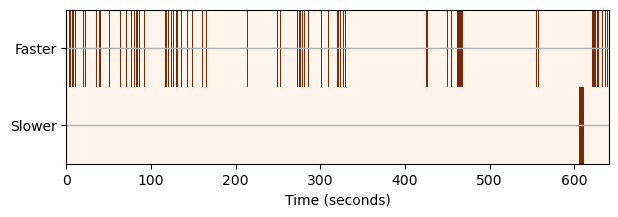

In [3]:
##############################################################
# set normal IBI range and visualize abnormal ones
##############################################################
t_range = (10, 401) ## unit: BPM, IBIs outside of this range will be visualized
fontsize = 10
xinterval = 10
#### try one track first

select_ind = 0
selected_track_df = dfs_select.iloc[select_ind, :]
# display(selected_track_df)
annpath = os.path.join('./', 'annotations', selected_track_df['Wavpath'].replace('.wav', '.beats'))

### read annotations
beat_ann = np.loadtxt(annpath )[:, 0]
bool_array = normalIBIboolarray(beat_ann, t_range = t_range , FPS = Beat_FPS)

print(os.path.basename(annpath ))
fig = abnmIBIvis(bool_array, fontsize = fontsize, xinterval = 100)

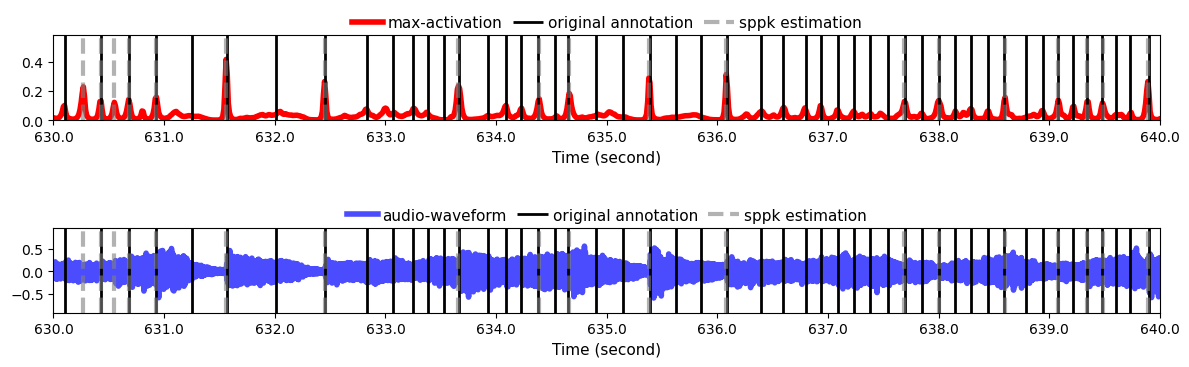

In [4]:
##########################################################################################
# Zoom in for a specific time region and see the time domain activtion and signal
# SPPK: simple peak picking method which convert activations (>0.1) to beat estimations
##########################################################################################
# print(selected_track_df['Wavpath'])
start_sec = 630
dur_sec = 10
wavpath = os.path.join('./', 'audio', selected_track_df['Wavpath'])
src_dict = getSRCs(wavpath, dataset = target_set)
fig = plotSRCs(src_dict, annshift = None, 
               figsize = (12, 4), fontsize = 11, start_frame = start_sec*Beat_FPS, dur = dur_sec*Beat_FPS)

In [5]:
###----------------------###
 # sonification--zoom-in  #
###----------------------###

songpath = os.path.join('./', 'audio', selected_track_df['Wavpath'])
audio, rate = sf.read(songpath)
beat_est = np.loadtxt(src_dict['estipath'])
ann_ori = np.loadtxt(src_dict['annpath'])[:, 0]

### stereo tracks
if len(audio.shape)==2:
    audio = audio.mean(axis = 1)
print("==="*20)
print("Track Name:{}".format(os.path.basename(songpath)))
print("==="*20)
print("---> duration:{:.2f} sec, sampling rate:{}".format(len(audio)/rate, rate))

print("================")
print("original audio")
print("================")
audio_cut = audio[start_sec*rate:(start_sec+dur_sec)*rate]
ipd.display(ipd.Audio(audio_cut, rate = rate))
# ipd.display(ipd.Audio(audio, rate = rate))


print("====================")
print("original annotations")
print("====================")
### play audio with click
print("annotation path:{}".format(src_dict['annpath']))
audio_click = add_click(audio, ann_ori, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))
audio_click_cut = audio_click[start_sec*rate:(start_sec + dur_sec)*rate]
ipd.display(ipd.Audio(audio_click_cut, rate = rate))

print("============================================")
print("simple peak picking estimations")
print("============================================")
### play audio with click
audio_click = add_click(audio, beat_est, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))
audio_click_cut = audio_click[start_sec*rate:(start_sec + dur_sec)*rate]
ipd.display(ipd.Audio(audio_click_cut, rate = rate))

Track Name:Liszt_Mephisto_Waltz_Tysman07M.wav
---> duration:642.60 sec, sampling rate:44100
original audio


original annotations
annotation path:./annotations/Liszt_Mephisto_Waltz_Tysman07M.beats


simple peak picking estimations


In [6]:
###-------------------------###
 # sonification-- fulltrack  #
###-------------------------###
audio, rate = sf.read(songpath)
beat_est = np.loadtxt(src_dict['estipath'])
ann_ori = np.loadtxt(src_dict['annpath'])[:, 0]

### stereo tracks
if len(audio.shape)==2:
    audio = audio.mean(axis = 1)
print("==="*20)
print("Track Name:{}".format(os.path.basename(songpath)))
print("==="*20)
print("---> duration:{:.2f} sec, sampling rate:{}".format(len(audio)/rate, rate))

print("================")
print("original audio")
print("================")
# ipd.display(ipd.Audio(audio, rate = rate))

print("====================")
print("original annotations")
print("====================")
### play audio with click
print("annotation path:{}".format(src_dict['annpath']))
audio_click = add_click(audio, ann_ori, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))

print("============================================")
print("simple peak picking estimations")
print("============================================")
### play audio with click
audio_click = add_click(audio, beat_est, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))

Track Name:Liszt_Mephisto_Waltz_Tysman07M.wav
---> duration:642.60 sec, sampling rate:44100
original audio
original annotations
annotation path:./annotations/Liszt_Mephisto_Waltz_Tysman07M.beats
simple peak picking estimations
